# 01 - Análisis Exploratorio de Datos (EDA)

Este notebook realiza un análisis exploratorio completo del dataset de señales EEG para imaginación motora (MI).

## Objetivos

1. **Carga y verificación de datos**: Validar la integridad y estructura del dataset
2. **Análisis descriptivo**: Estadísticas básicas de las señales EEG
3. **Visualización de datos**: Representaciones gráficas de las señales
4. **Análisis de calidad**: Detección de artefactos y canales problemáticos
5. **Análisis de distribución**: Verificar balance de clases y sujetos
6. **Análisis espectral**: Explorar características en el dominio de frecuencia
7. **Análisis temporal**: Características temporales de las señales


## 1. Importaciones y Configuración


In [20]:
# Importaciones
import numpy as np
import pandas as pd
from pathlib import Path
import warnings
import json
from datetime import datetime
warnings.filterwarnings('ignore')

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# MNE para carga de archivos EEGLAB
try:
    import mne
except ImportError:
    print("Instalando mne...")
    import subprocess
    subprocess.check_call(["pip", "install", "-q", "mne"])
    import mne

# Para descarga de Google Drive y manejo de ZIP
try:
    import gdown
except ImportError:
    print("Instalando gdown...")
    import subprocess
    subprocess.check_call(["pip", "install", "-q", "gdown"])
    import gdown

import zipfile
import shutil

# Configuración del proyecto
CONFIG = {
    'n_subjects': 20,  # Ajustado según los datos reales
    'n_channels': 64,
    'n_trials_per_subject': 22,
    'sampling_rate': 128,
    'trial_duration': 9.0,
    'trial_window': (-3.0, 6.0),
    'n_samples_per_trial': 1152,
    'filter_low': 8,
    'filter_high': 30,
    'random_seed': 42,
    'data_dir': 'data',
    'results_dir': 'results',
    'google_drive_folder_id': '1aWFshMYbSlhPTZbLKldJ2Rbv7JZVYwrW',
    'google_drive_url': 'https://drive.google.com/drive/folders/1aWFshMYbSlhPTZbLKldJ2Rbv7JZVYwrW?usp=drive_link',
    'zip_left_names': ['imag_left.zip', 'left_imag.zip', 'left.zip'],
    'zip_right_names': ['imag_right.zip', 'right_imag.zip', 'right.zip']
}

# Crear directorios necesarios
for dir_name in [CONFIG['data_dir'], CONFIG['results_dir']]:
    Path(dir_name).mkdir(exist_ok=True, parents=True)
Path(CONFIG['data_dir']).joinpath('left_imag').mkdir(exist_ok=True, parents=True)
Path(CONFIG['data_dir']).joinpath('right_imag').mkdir(exist_ok=True, parents=True)

print("Importaciones completadas")
print(f"MNE version: {mne.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")


Importaciones completadas
MNE version: 1.11.0
NumPy version: 1.26.4
Pandas version: 2.3.3


## 2. Funciones Auxiliares


In [21]:
# Función auxiliar para extraer datos numéricos de estructuras complejas
def extract_numeric_data(data):
    """Extrae datos numéricos de una estructura, manejando diferentes formatos"""
    # Si ya es un array numpy numérico, retornarlo
    if isinstance(data, np.ndarray):
        if np.issubdtype(data.dtype, np.number):
            return np.asarray(data, dtype=np.float64)
        
        # Si es un array estructurado (tiene campos)
        if hasattr(data, 'dtype') and data.dtype.names:
            # Buscar el campo 'data'
            if 'data' in data.dtype.names:
                field_data = data['data']
                if isinstance(field_data, np.ndarray):
                    # Acceder al contenido (puede estar anidado)
                    if field_data.size == 1:
                        field_data = field_data.item()
                    return extract_numeric_data(field_data)
            
            # Buscar cualquier campo numérico
            for name in data.dtype.names:
                field = data[name]
                if isinstance(field, np.ndarray):
                    field_val = field.item() if field.size == 1 else field
                    if isinstance(field_val, np.ndarray) and np.issubdtype(field_val.dtype, np.number):
                        return np.asarray(field_val, dtype=np.float64)
    
    # Intentar convertir a array numpy
    try:
        data_array = np.asarray(data)
        if np.issubdtype(data_array.dtype, np.number):
            return np.asarray(data_array, dtype=np.float64)
    except:
        pass
    
    raise ValueError(f"No se pudieron extraer datos numéricos de la estructura")

# Función auxiliar para leer archivos EEGLAB (.set)
def load_eeglab_file(file_path):
    """Lee archivos EEGLAB (.set) usando MNE como método principal"""
    try:
        # Método 1: Intentar leer como epochs (más común en EEGLAB)
        try:
            epochs = mne.read_epochs_eeglab(str(file_path), verbose=False)
            data = epochs.get_data()  # Formato: (n_epochs, n_channels, n_times)
            
            # Diagnóstico
            if len(data.shape) == 3:
                print(f"{file_path.name}: Shape epochs = {data.shape}, std = {np.std(data):.6e}")
            
            # Si hay múltiples epochs, necesitamos manejar esto correctamente
            if len(data.shape) == 3:
                # data.shape = (n_epochs, n_channels, n_times)
                n_epochs, n_channels, n_times = data.shape
                print(f"{file_path.name}: Epochs detectadas: {n_epochs} epochs, {n_channels} canales, {n_times} muestras")
                
                # Verificar variación antes y después de extraer
                std_before = np.std(data)
                print(f"{file_path.name}: Std antes de extraer epoch: {std_before:.6e}")
                
                # Para análisis EDA, promediar todas las epochs o concatenar
                # Pero primero verifiquemos cada epoch individualmente
                epochs_stds = [np.std(data[i]) for i in range(min(3, n_epochs))]
                print(f"{file_path.name}: Std de primeras 3 epochs: {epochs_stds}")
                
                # Si todas las epochs tienen variación, tomar la primera
                if n_epochs == 1:
                    data = data[0]  # (n_channels, n_times)
                else:
                    # Para EDA, podemos promediar las epochs o tomar una representativa
                    # Primero intentemos con la primera epoch
                    first_epoch = data[0]
                    first_std = np.std(first_epoch)
                    
                    # Si la primera epoch tiene poca variación, buscar una con más variación
                    if first_std < 1e-6:
                        print(f"{file_path.name}: Primera epoch tiene poca variación (std={first_std:.6e})")
                        # Buscar epoch con mayor variación
                        epoch_stds = [np.std(data[i]) for i in range(n_epochs)]
                        best_epoch_idx = np.argmax(epoch_stds)
                        data = data[best_epoch_idx]
                        print(f"{file_path.name}: Usando epoch {best_epoch_idx} con std={epoch_stds[best_epoch_idx]:.6e}")
                    else:
                        data = first_epoch
            
            data = np.asarray(data, dtype=np.float64)
            
            # Diagnóstico detallado
            data_std = np.std(data)
            data_mean = np.mean(data)
            data_min = np.min(data)
            data_max = np.max(data)
            
            print(f"   {file_path.name}: Datos extraídos - shape={data.shape}, std={data_std:.6e}, mean={data_mean:.6e}")
            
            if data_std < 1e-10:
                print(f"ERROR CRÍTICO: {file_path.name} - Datos extraídos son constantes!")
                print(f"Shape: {data.shape}, Mean: {data_mean:.6e}, Std: {data_std:.6e}")
                print(f"Min: {data_min:.6e}, Max: {data_max:.6e}")
                # Intentar método alternativo
                raise ValueError("Datos constantes después de extracción, intentando método alternativo")
            
            return data, epochs.info
        except Exception as epochs_error:
            # Método 2: Intentar leer como raw
            try:
                raw = mne.io.read_raw_eeglab(str(file_path), preload=True, verbose=False)
                data = raw.get_data()  # Formato: (n_channels, n_times)
                data = np.asarray(data, dtype=np.float64)
                
                # Diagnóstico detallado
                data_std = np.std(data)
                if data_std < 1e-10:
                    print(f"ADVERTENCIA: {file_path.name} - Datos raw parecen constantes")
                    print(f"Shape: {data.shape}, Std: {data_std:.6e}")
                    raise ValueError("Datos raw constantes, intentando método alternativo")
                
                return data, raw.info
            except Exception as raw_error:
                # Método 3: Usar scipy.io.loadmat directamente
                from scipy.io import loadmat
                print(f"{file_path.name}: Usando scipy.io.loadmat (MNE falló)")
                
                mat = loadmat(str(file_path), simplify_cells=False)
                
                # Buscar estructura EEG
                if 'EEG' not in mat:
                    raise ValueError(f"Campo 'EEG' no encontrado en {file_path.name}")
                
                eeg_struct = mat['EEG']
                if not isinstance(eeg_struct, np.ndarray) or eeg_struct.size == 0:
                    raise ValueError(f"Estructura EEG vacía en {file_path.name}")
                
                # Acceder al objeto EEG
                eeg_item = eeg_struct[0, 0] if eeg_struct.ndim >= 2 else eeg_struct.item()
                
                # Extraer el campo 'data'
                if not hasattr(eeg_item, 'dtype') or not eeg_item.dtype.names or 'data' not in eeg_item.dtype.names:
                    raise ValueError(f"Campo 'data' no encontrado en estructura EEG")
                
                data_field = eeg_item['data']
                
                # Diagnóstico de la estructura
                print(f"{file_path.name}: data_field type = {type(data_field)}, shape = {getattr(data_field, 'shape', 'N/A')}")
                
                # Extraer datos recursivamente
                if isinstance(data_field, np.ndarray):
                    if data_field.size == 1:
                        data = data_field.item()
                    else:
                        data = data_field
                    
                    # Extraer recursivamente si es estructurado
                    depth = 0
                    max_depth = 10
                    while isinstance(data, np.ndarray) and hasattr(data, 'dtype') and depth < max_depth:
                        depth += 1
                        if data.dtype.names:
                            if 'data' in data.dtype.names:
                                data = data['data']
                                if isinstance(data, np.ndarray) and data.size == 1:
                                    data = data.item()
                            else:
                                break
                        elif np.issubdtype(data.dtype, np.number):
                            break
                        else:
                            break
                    
                    data = np.asarray(data, dtype=np.float64)
                    
                    print(f"{file_path.name}: Después de extracción - shape = {data.shape}, std = {np.std(data):.6e}")
                    
                    # Manejar formas 2D y 3D
                    if len(data.shape) == 3:
                        print(f"{file_path.name}: Datos 3D detectados, shape = {data.shape}")
                        # EEGLAB típicamente usa (channels, time, epochs)
                        if data.shape[0] < data.shape[1]:
                            data = data[:, :, 0]  # Tomar primera epoch
                        else:
                            data = data[0, :, :]  # Tomar primera epoch
                    
                    # Verificar orientación para 2D
                    if len(data.shape) == 2:
                        # Si parece (time, channels), transponer
                        if data.shape[0] > data.shape[1] * 2:
                            print(f"{file_path.name}: Transponiendo datos (time, channels) -> (channels, time)")
                            data = data.T
                    
                    # Verificación final
                    final_std = np.std(data)
                    final_mean = np.mean(data)
                    final_min = np.min(data)
                    final_max = np.max(data)
                    
                    print(f"{file_path.name}: Final - shape = {data.shape}, mean = {final_mean:.6e}, std = {final_std:.6e}")
                    print(f"Min = {final_min:.6e}, Max = {final_max:.6e}")
                    
                    if final_std < 1e-10:
                        print(f"ADVERTENCIA CRÍTICA: {file_path.name} - Datos finales son constantes!")
                    
                    return data, None
                else:
                    raise ValueError(f"Campo 'data' no es un array numpy, tipo: {type(data_field)}")
                    
    except Exception as e:
        raise ValueError(f"Error al leer archivo {file_path.name}: {str(e)}")

# Función para descargar datos del Google Drive si no existen
def download_data_from_drive(data_dir='data', folder_id=None, config=None):
    """Descarga archivos ZIP del Google Drive y los extrae en las carpetas correspondientes"""
    if config is None:
        config = CONFIG
    if folder_id is None:
        folder_id = config.get('google_drive_folder_id', '1aWFshMYbSlhPTZbLKldJ2Rbv7JZVYwrW')
    
    data_path = Path(data_dir)
    left_dir = data_path / 'left_imag'
    right_dir = data_path / 'right_imag'
    
    left_dir.mkdir(exist_ok=True, parents=True)
    right_dir.mkdir(exist_ok=True, parents=True)
    
    left_files = list(left_dir.glob('*.set'))
    right_files = list(right_dir.glob('*.set'))
    
    if len(left_files) > 0 and len(right_files) > 0:
        print(f"Datos encontrados: {len(left_files)} archivos en left_imag, {len(right_files)} archivos en right_imag")
        return
    
    print("No se encontraron datos locales. Descargando ZIPs del Google Drive...")
    print(f"URL: {config.get('google_drive_url', 'N/A')}")
    
    try:
        temp_download_dir = data_path / 'temp_downloads'
        temp_download_dir.mkdir(exist_ok=True, parents=True)
        
        gdown.download_folder(
            id=folder_id,
            output=str(temp_download_dir),
            quiet=False,
            use_cookies=False
        )
        
        zip_files = list(temp_download_dir.glob('*.zip'))
        if len(zip_files) == 0:
            zip_files = list(temp_download_dir.rglob('*.zip'))
        
        print(f"Encontrados {len(zip_files)} archivo(s) ZIP")
        
        left_zip = None
        right_zip = None
        zip_left_names = config.get('zip_left_names', ['imag_left.zip', 'left_imag.zip', 'left.zip'])
        zip_right_names = config.get('zip_right_names', ['imag_right.zip', 'right_imag.zip', 'right.zip'])
        
        for zip_file in zip_files:
            zip_name_lower = zip_file.name.lower()
            if not left_zip:
                for name_pattern in zip_left_names:
                    if name_pattern.lower() in zip_name_lower or 'left' in zip_name_lower:
                        left_zip = zip_file
                        print(f"Identificado ZIP izquierdo: {zip_file.name}")
                        break
            if not right_zip:
                for name_pattern in zip_right_names:
                    if name_pattern.lower() in zip_name_lower or 'right' in zip_name_lower:
                        right_zip = zip_file
                        print(f"Identificado ZIP derecho: {zip_file.name}")
                        break
        
        if not left_zip and len(zip_files) >= 2:
            left_zip = zip_files[0]
            right_zip = zip_files[1]
        
        def extract_zip_smartly(zip_file, target_dir, zip_name):
            """Extrae un ZIP evitando crear carpetas anidadas"""
            temp_extract = target_dir.parent / f'temp_extract_{zip_name}'
            temp_extract.mkdir(exist_ok=True, parents=True)
            
            with zipfile.ZipFile(zip_file, 'r') as zip_ref:
                zip_ref.extractall(temp_extract)
            
            nested_dir = None
            for item in temp_extract.iterdir():
                if item.is_dir() and (item.name.lower() in ['left_imag', 'right_imag', 'left', 'right']):
                    nested_dir = item
                    break
            
            if nested_dir:
                print(f"Detectada carpeta '{nested_dir.name}' dentro del ZIP")
                for file in nested_dir.rglob('*'):
                    if file.is_file():
                        relative = file.relative_to(nested_dir)
                        target_file = target_dir / relative
                        target_file.parent.mkdir(parents=True, exist_ok=True)
                        shutil.move(str(file), str(target_file))
                print(f"Contenido movido de {nested_dir.name} a {target_dir.name}/")
            else:
                for file in temp_extract.rglob('*'):
                    if file.is_file():
                        relative = file.relative_to(temp_extract)
                        target_file = target_dir / relative
                        target_file.parent.mkdir(parents=True, exist_ok=True)
                        shutil.move(str(file), str(target_file))
            
            shutil.rmtree(temp_extract)
        
        if left_zip:
            print(f"Extrayendo {left_zip.name} a left_imag/...")
            extract_zip_smartly(left_zip, left_dir, 'left')
        if right_zip:
            print(f"Extrayendo {right_zip.name} a right_imag/...")
            extract_zip_smartly(right_zip, right_dir, 'right')
        
        if temp_download_dir.exists():
            shutil.rmtree(temp_download_dir)
        
        downloaded_left = list(left_dir.glob('*.set'))
        downloaded_right = list(right_dir.glob('*.set'))
        
        if len(downloaded_left) > 0 or len(downloaded_right) > 0:
            print(f"Descarga y extracción completada:")
            print(f"- left_imag: {len(downloaded_left)} archivos .set")
            print(f"- right_imag: {len(downloaded_right)} archivos .set")
        
    except Exception as e:
        print(f"Error al descargar o extraer: {e}")
        raise

print("Funciones auxiliares definidas")


Funciones auxiliares definidas


## 3. Carga de Datos


In [22]:
# Verificar y descargar datos si es necesario
download_data_from_drive(config=CONFIG)

# Cargar todos los datos
data_path = Path(CONFIG['data_dir'])
left_dir = data_path / 'left_imag'
right_dir = data_path / 'right_imag'

# Buscar archivos .set (manejando posibles carpetas anidadas)
left_files = []
right_files = []

# Buscar en left_imag (incluyendo subcarpetas)
for pattern in ['*.set', '**/*.set']:
    left_files.extend(left_dir.glob(pattern))
    right_files.extend(right_dir.glob(pattern))

# Remover duplicados y archivos de __MACOSX
left_files = [f for f in left_files if '__MACOSX' not in str(f) and f.is_file()]
right_files = [f for f in right_files if '__MACOSX' not in str(f) and f.is_file()]

left_files = sorted(set(left_files))[:len(left_files)]  # Mantener orden
right_files = sorted(set(right_files))[:len(right_files)]

print(f"Archivos encontrados:")
print(f"- Left: {len(left_files)} archivos")
print(f"- Right: {len(right_files)} archivos")

# Extraer información de sujetos desde los nombres de archivos
def extract_subject_info(file_path):
    """Extrae información del sujeto desde el nombre del archivo"""
    filename = file_path.stem  # Sin extensión
    parts = filename.split('_')
    subject_id = None
    task = None
    
    for part in parts:
        if part.startswith('S') and part[1:].isdigit():
            subject_id = int(part[1:])
        elif 'Task' in part or 'task' in part.lower():
            task = part
    
    return subject_id, task

# Cargar datos con información de sujetos
data_info = {
    'left': [],
    'right': []
}

print("\\nCargando datos...")
for idx, file_path in enumerate(left_files):
    try:
        data, info = load_eeglab_file(file_path)
        subject_id, task = extract_subject_info(file_path)
        
        # Asegurar que data sea un array numpy numérico limpio
        # La función load_eeglab_file ya debería devolver datos limpios, pero verificamos
        if not isinstance(data, np.ndarray) or not np.issubdtype(data.dtype, np.number):
            try:
                data = extract_numeric_data(data)
            except:
                print(f"Advertencia: No se pudieron limpiar datos de {file_path.name}")
                continue
        
        data = np.asarray(data, dtype=np.float64)
        
        # Validación inmediata después de cargar
        data_std = np.std(data)
        data_mean = np.mean(data)
        data_min = np.min(data)
        data_max = np.max(data)
        
        if data_std < 1e-10:
            print(f"ERROR: {file_path.name} - Datos cargados son constantes (std={data_std:.2e})")
            print(f" Shape: {data.shape}, Mean: {data_mean:.6e}, Min: {data_min:.6e}, Max: {data_max:.6e}")
            print(f"Este archivo será omitido")
            continue
        
        # Verificar que tenga dimensiones válidas
        if len(data.shape) < 2:
            print(f"Advertencia: {file_path.name} - Shape inválido: {data.shape}, omitiendo")
            continue
        
        data_info['left'].append({
            'data': data,
            'info': info,
            'subject_id': subject_id,
            'task': task,
            'file_path': file_path,
            'label': 0  # Left = 0
        })
        if (idx + 1) % 5 == 0:
            print(f"Left: {idx + 1}/{len(left_files)} archivos cargados...")
    except Exception as e:
        print(f"Error cargando {file_path.name}: {e}")

print(f"Left: {len(data_info['left'])} archivos cargados exitosamente")

for idx, file_path in enumerate(right_files):
    try:
        data, info = load_eeglab_file(file_path)
        subject_id, task = extract_subject_info(file_path)
        
        # Asegurar que data sea un array numpy numérico limpio
        # La función load_eeglab_file ya debería devolver datos limpios, pero verificamos
        if not isinstance(data, np.ndarray) or not np.issubdtype(data.dtype, np.number):
            try:
                data = extract_numeric_data(data)
            except:
                print(f"Advertencia: No se pudieron limpiar datos de {file_path.name}")
                continue
        
        data = np.asarray(data, dtype=np.float64)
        
        # Validación inmediata después de cargar
        data_std = np.std(data)
        data_mean = np.mean(data)
        data_min = np.min(data)
        data_max = np.max(data)
        
        if data_std < 1e-10:
            print(f"ERROR: {file_path.name} - Datos cargados son constantes (std={data_std:.2e})")
            print(f"Shape: {data.shape}, Mean: {data_mean:.6e}, Min: {data_min:.6e}, Max: {data_max:.6e}")
            print(f"Este archivo será omitido")
            continue
        
        # Verificar que tenga dimensiones válidas
        if len(data.shape) < 2:
            print(f"Advertencia: {file_path.name} - Shape inválido: {data.shape}, omitiendo")
            continue
        
        data_info['right'].append({
            'data': data,
            'info': info,
            'subject_id': subject_id,
            'task': task,
            'file_path': file_path,
            'label': 1  # Right = 1
        })
        if (idx + 1) % 5 == 0:
            print(f"Right: {idx + 1}/{len(right_files)} archivos cargados...")
    except Exception as e:
        print(f"Error cargando {file_path.name}: {e}")

print(f"Right: {len(data_info['right'])} archivos cargados exitosamente")

print(f"\nCarga completada:")
print(f"- Total Left: {len(data_info['left'])} trials")
print(f"- Total Right: {len(data_info['right'])} trials")
print(f"- Total: {len(data_info['left']) + len(data_info['right'])} trials")


No se encontraron datos locales. Descargando ZIPs del Google Drive...
URL: https://drive.google.com/drive/folders/1aWFshMYbSlhPTZbLKldJ2Rbv7JZVYwrW?usp=drive_link


Retrieving folder contents


Processing file 1PA2xDJw2N7Fv9Fv29jF7nKL3HAjIqmAb left_imag.zip
Processing file 1o-J0rmzFESP9EGsAh-sZvPhxXBUGrCA2 right_imag.zip


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1PA2xDJw2N7Fv9Fv29jF7nKL3HAjIqmAb
From (redirected): https://drive.google.com/uc?id=1PA2xDJw2N7Fv9Fv29jF7nKL3HAjIqmAb&confirm=t&uuid=f3328d63-e1f8-4abd-9d9e-47c3a68f1c39
To: /Users/manueljurado/doctorado/eeg-mi-deep-learning/data/temp_downloads/left_imag.zip
100%|██████████| 239M/239M [01:07<00:00, 3.51MB/s] 
Downloading...
From (original): https://drive.google.com/uc?id=1o-J0rmzFESP9EGsAh-sZvPhxXBUGrCA2
From (redirected): https://drive.google.com/uc?id=1o-J0rmzFESP9EGsAh-sZvPhxXBUGrCA2&confirm=t&uuid=d67e7a78-5e13-43ee-a556-f9291f0fa802
To: /Users/manueljurado/doctorado/eeg-mi-deep-learning/data/temp_downloads/right_imag.zip
100%|██████████| 237M/237M [01:11<00:00, 3.34MB/s] 
Download completed


Encontrados 2 archivo(s) ZIP
Identificado ZIP izquierdo: left_imag.zip
Identificado ZIP derecho: right_imag.zip
Extrayendo left_imag.zip a left_imag/...
Detectada carpeta 'left_imag' dentro del ZIP
Contenido movido de left_imag a left_imag/
Extrayendo right_imag.zip a right_imag/...
Detectada carpeta 'right_imag' dentro del ZIP
Contenido movido de right_imag a right_imag/
Descarga y extracción completada:
- left_imag: 20 archivos .set
- right_imag: 20 archivos .set
Archivos encontrados:
- Left: 20 archivos
- Right: 20 archivos
\nCargando datos...
S001_Task2_PREP_Left.set: Shape epochs = (22, 64, 1152), std = 1.334253e-05
S001_Task2_PREP_Left.set: Epochs detectadas: 22 epochs, 64 canales, 1152 muestras
S001_Task2_PREP_Left.set: Std antes de extraer epoch: 1.334253e-05
S001_Task2_PREP_Left.set: Std de primeras 3 epochs: [1.3563403459169603e-05, 1.5924972417088714e-05, 1.1848739996046035e-05]
   S001_Task2_PREP_Left.set: Datos extraídos - shape=(64, 1152), std=1.356340e-05, mean=1.212940e

## 4. Análisis Descriptivo


In [23]:
# Estadísticas descriptivas
stats_left = []
stats_right = []

def extract_numeric_data(data):
    """Extrae datos numéricos de una estructura, manejando diferentes formatos"""
    # Si ya es un array numpy numérico, retornarlo
    if isinstance(data, np.ndarray):
        if np.issubdtype(data.dtype, np.number):
            return np.asarray(data, dtype=np.float64)
    
    # Intentar convertir a array numpy
    try:
        data_array = np.asarray(data, dtype=np.float64)
        if np.issubdtype(data_array.dtype, np.number):
            return data_array
    except:
        pass
    
    # Si tiene estructura, intentar extraer el campo 'data'
    if hasattr(data, 'dtype') and data.dtype.names:
        if 'data' in data.dtype.names:
            return extract_numeric_data(data['data'])
    
    # Si es un objeto estructurado de MATLAB/EEGLAB
    if isinstance(data, np.ndarray) and data.dtype.names:
        # Buscar campos numéricos
        for name in data.dtype.names:
            field = data[name]
            if isinstance(field, np.ndarray) and np.issubdtype(field.dtype, np.number):
                return np.asarray(field, dtype=np.float64)
    
    raise ValueError(f"No se pudieron extraer datos numéricos de la estructura")

for item in data_info['left']:
    data = item['data']
    try:
        # Verificar que data sea un array numpy numérico
        if not isinstance(data, np.ndarray):
            data = extract_numeric_data(data)
        elif not np.issubdtype(data.dtype, np.number):
            data = extract_numeric_data(data)
        
        # Asegurar tipo numérico
        data = np.asarray(data, dtype=np.float64)
        
        # Si es 3D, reducir a 2D
        if len(data.shape) == 3:
            data = data[0] if data.shape[0] == 1 else np.mean(data, axis=0)
        
        # Verificar que sea 2D
        if len(data.shape) != 2:
            print(f"Forma inesperada para left trial del sujeto {item['subject_id']}: {data.shape}")
            continue
        
        # Calcular estadísticas
        stats_left.append({
            'subject_id': item['subject_id'],
            'shape': data.shape,
            'n_channels': int(data.shape[0]),
            'n_samples': int(data.shape[1]),
            'mean': float(np.nanmean(data)),
            'std': float(np.nanstd(data)),
            'min': float(np.nanmin(data)),
            'max': float(np.nanmax(data)),
            'range': float(np.nanmax(data) - np.nanmin(data))
        })
    except Exception as e:
        print(f"Error procesando left trial del sujeto {item.get('subject_id', 'unknown')}: {e}")
        import traceback
        print(f"{traceback.format_exc()}")

for item in data_info['right']:
    data = item['data']
    try:
        # Verificar que data sea un array numpy numérico
        if not isinstance(data, np.ndarray):
            data = extract_numeric_data(data)
        elif not np.issubdtype(data.dtype, np.number):
            data = extract_numeric_data(data)
        
        # Asegurar tipo numérico
        data = np.asarray(data, dtype=np.float64)
        
        # Si es 3D, reducir a 2D
        if len(data.shape) == 3:
            data = data[0] if data.shape[0] == 1 else np.mean(data, axis=0)
        
        # Verificar que sea 2D
        if len(data.shape) != 2:
            print(f"Forma inesperada para right trial del sujeto {item['subject_id']}: {data.shape}")
            continue
        
        # Calcular estadísticas
        stats_right.append({
            'subject_id': item['subject_id'],
            'shape': data.shape,
            'n_channels': int(data.shape[0]),
            'n_samples': int(data.shape[1]),
            'mean': float(np.nanmean(data)),
            'std': float(np.nanstd(data)),
            'min': float(np.nanmin(data)),
            'max': float(np.nanmax(data)),
            'range': float(np.nanmax(data) - np.nanmin(data))
        })
    except Exception as e:
        print(f"Error procesando right trial del sujeto {item.get('subject_id', 'unknown')}: {e}")
        import traceback
        print(f"     {traceback.format_exc()}")

df_left = pd.DataFrame(stats_left)
df_right = pd.DataFrame(stats_right)

print("ESTADÍSTICAS DESCRIPTIVAS")
print("="*60)
print("\nLEFT HAND IMAGERY:")
print(df_left.describe())
print(f"\nResumen Left:")
print(f"- Total trials: {len(df_left)}")
print(f"- Canales promedio: {df_left['n_channels'].mean():.1f}")
print(f"- Muestras promedio: {df_left['n_samples'].mean():.1f}")
print(f"- Sujetos únicos: {df_left['subject_id'].nunique()}")

print("\n" + "="*60)
print("\nRIGHT HAND IMAGERY:")
print(df_right.describe())
print(f"\nResumen Right:")
print(f"- Total trials: {len(df_right)}")
print(f"- Canales promedio: {df_right['n_channels'].mean():.1f}")
print(f"- Muestras promedio: {df_right['n_samples'].mean():.1f}")
print(f"- Sujetos únicos: {df_right['subject_id'].nunique()}")

# Análisis de distribución por sujeto
subjects_left = df_left['subject_id'].value_counts().sort_index()
subjects_right = df_right['subject_id'].value_counts().sort_index()

print("\n" + "="*60)
print("\nDISTRIBUCIÓN POR SUJETO:")
print(f"\nLeft trials por sujeto:")
for subject, count in subjects_left.items():
    print(f"S{subject:02d}: {count} trials")

print(f"\nRight trials por sujeto:")
for subject, count in subjects_right.items():
    print(f"S{subject:02d}: {count} trials")


ESTADÍSTICAS DESCRIPTIVAS

LEFT HAND IMAGERY:
       subject_id  n_channels  n_samples          mean        std        min  \
count    20.00000        20.0       20.0  2.000000e+01  20.000000  20.000000   
mean     10.50000        64.0     1152.0  3.432527e-16   0.000010  -0.000063   
std       5.91608         0.0        0.0  1.044202e-15   0.000004   0.000027   
min       1.00000        64.0     1152.0 -2.040273e-15   0.000004  -0.000125   
25%       5.75000        64.0     1152.0 -2.754878e-16   0.000007  -0.000077   
50%      10.50000        64.0     1152.0  3.628198e-16   0.000009  -0.000061   
75%      15.25000        64.0     1152.0  9.549083e-16   0.000013  -0.000043   
max      20.00000        64.0     1152.0  2.258955e-15   0.000016  -0.000028   

             max      range  
count  20.000000  20.000000  
mean    0.000067   0.000130  
std     0.000032   0.000058  
min     0.000022   0.000056  
25%     0.000050   0.000094  
50%     0.000061   0.000117  
75%     0.000084   0.00

## 5. Visualizaciones


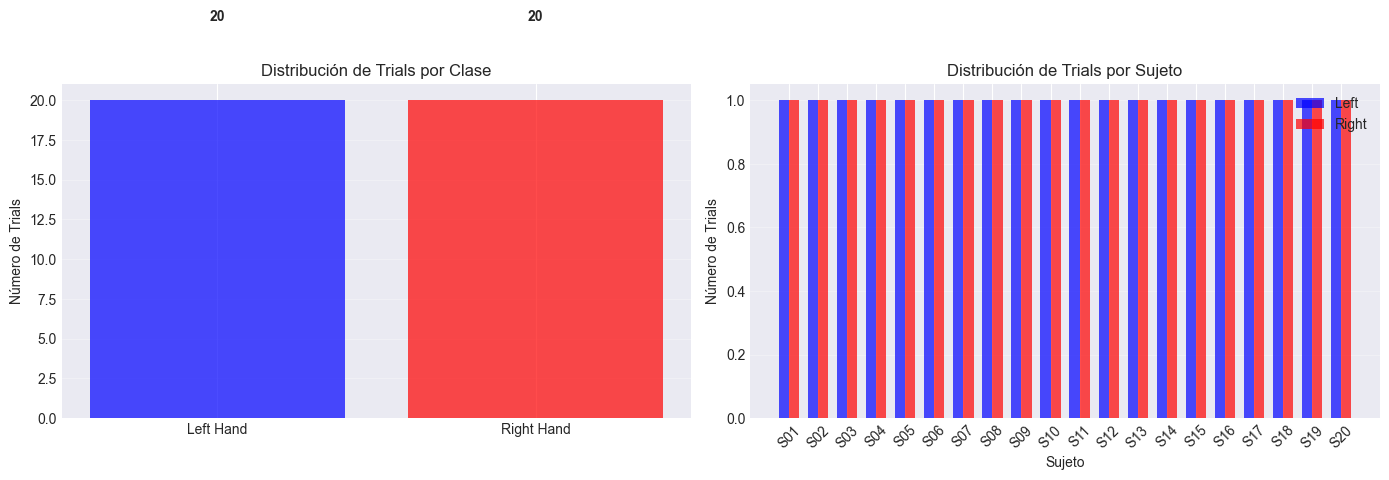

In [24]:
# 5.1 Distribución de trials por clase y sujeto
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribución por clase
class_counts = [len(data_info['left']), len(data_info['right'])]
axes[0].bar(['Left Hand', 'Right Hand'], class_counts, color=['blue', 'red'], alpha=0.7)
axes[0].set_ylabel('Número de Trials')
axes[0].set_title('Distribución de Trials por Clase')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(class_counts):
    axes[0].text(i, v + 5, str(v), ha='center', fontweight='bold')

# Distribución por sujeto
all_subjects = sorted(set(df_left['subject_id'].unique()) | set(df_right['subject_id'].unique()))
left_counts = [subjects_left.get(s, 0) for s in all_subjects]
right_counts = [subjects_right.get(s, 0) for s in all_subjects]

x = np.arange(len(all_subjects))
width = 0.35
axes[1].bar(x - width/2, left_counts, width, label='Left', color='blue', alpha=0.7)
axes[1].bar(x + width/2, right_counts, width, label='Right', color='red', alpha=0.7)
axes[1].set_xlabel('Sujeto')
axes[1].set_ylabel('Número de Trials')
axes[1].set_title('Distribución de Trials por Sujeto')
axes[1].set_xticks(x)
axes[1].set_xticklabels([f'S{s:02d}' for s in all_subjects], rotation=45)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(Path(CONFIG['results_dir']) / 'eda_distribution.png', dpi=150, bbox_inches='tight')
plt.show()


Seleccionando trials de ejemplo...
Total trials left: 20
Total trials right: 20
Seleccionado trial left 1: std=1.356340e-05
Seleccionado trial right 1: std=1.654080e-05
\nDiagnóstico de datos seleccionados:
Left shape: (64, 1152), dtype: float64
Right shape: (64, 1152), dtype: float64
Left:  min=-8.564420e-05, max=8.236298e-05, mean=1.212940e-15, std=1.356340e-05
Right: min=-8.028223e-05, max=8.553891e-05, mean=-1.420523e-15, std=1.654080e-05


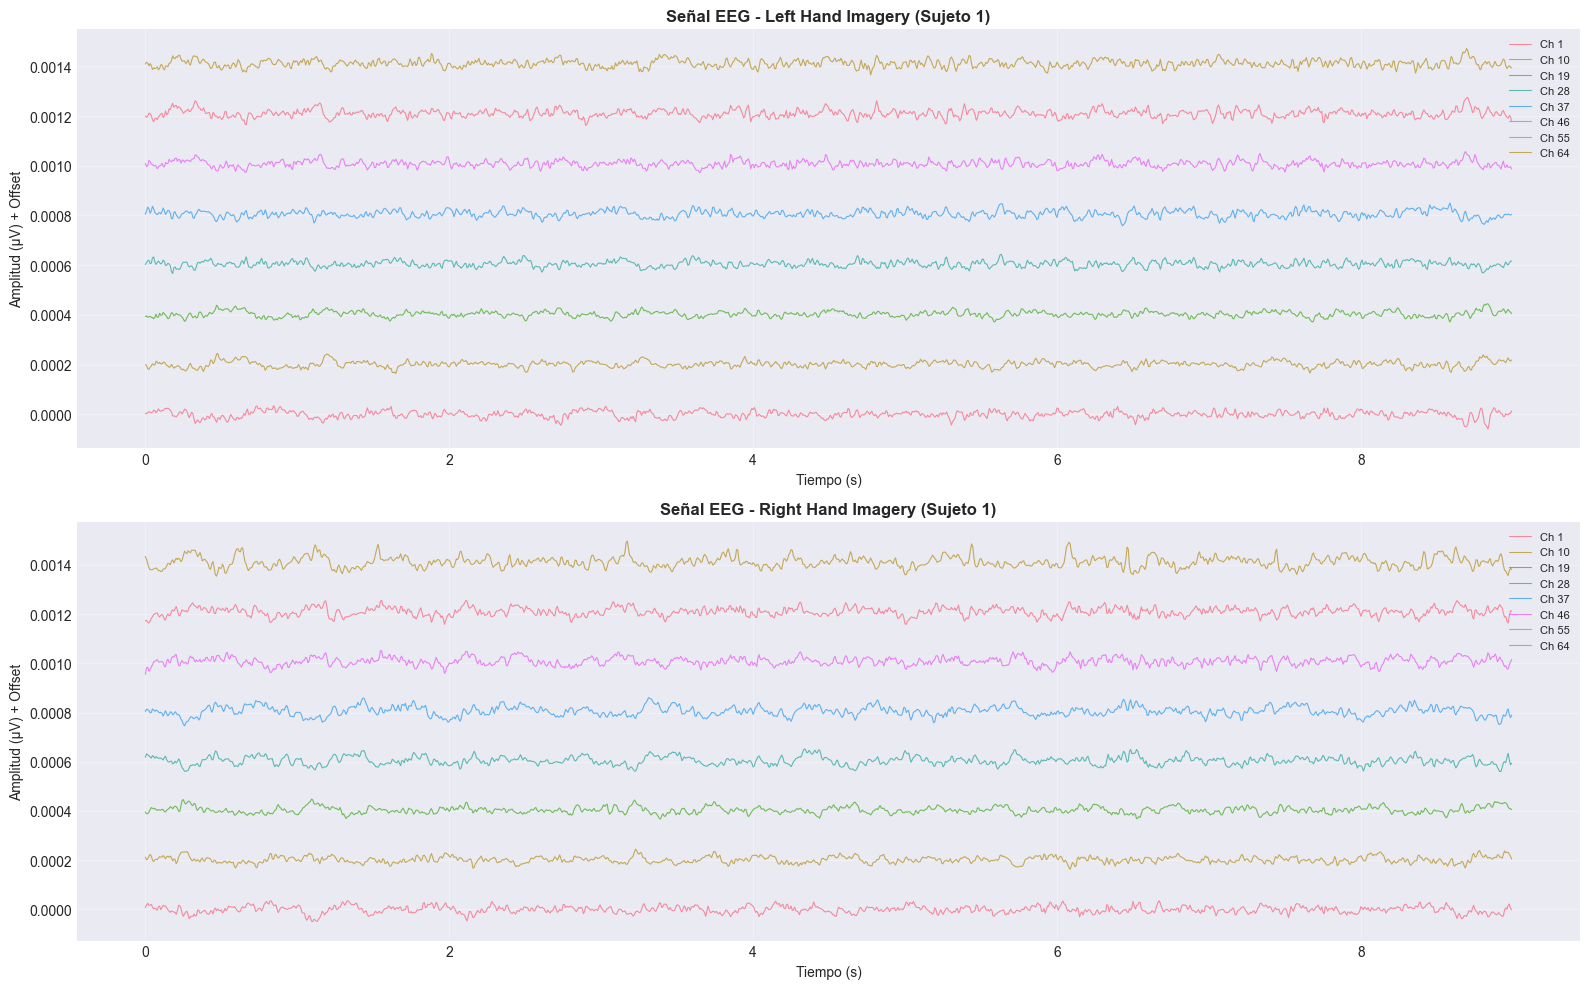


Estadísticas de variación por canal (primeros 5):
Canal 1: Left std=1.381017e-05, mean=-1.036724e-07 | Right std=1.416373e-05, mean=-3.396962e-07
Canal 2: Left std=9.954472e-06, mean=-3.411558e-08 | Right std=1.382705e-05, mean=-3.594641e-08
Canal 3: Left std=1.086253e-05, mean=-7.887664e-08 | Right std=1.522353e-05, mean=7.346818e-08
Canal 4: Left std=1.222203e-05, mean=-5.447391e-08 | Right std=1.802824e-05, mean=1.230126e-07
Canal 5: Left std=1.084859e-05, mean=-2.140958e-07 | Right std=1.429088e-05, mean=1.677010e-07


In [25]:
# 5.2 Visualización de señales EEG (ejemplo de un trial)
if len(data_info['left']) > 0 and len(data_info['right']) > 0:
    # Seleccionar un trial de ejemplo de cada clase
    print("Seleccionando trials de ejemplo...")
    print(f"Total trials left: {len(data_info['left'])}")
    print(f"Total trials right: {len(data_info['right'])}")
    
    # Buscar un trial con datos válidos (no constantes)
    left_example = None
    right_example = None
    
    for i in range(len(data_info['left'])):
        trial_data = data_info['left'][i]['data']
        if isinstance(trial_data, np.ndarray):
            trial_std = np.std(trial_data)
            if trial_std > 1e-6:
                left_example = trial_data.copy()
                print(f"Seleccionado trial left {i+1}: std={trial_std:.6e}")
                break
    
    for i in range(len(data_info['right'])):
        trial_data = data_info['right'][i]['data']
        if isinstance(trial_data, np.ndarray):
            trial_std = np.std(trial_data)
            if trial_std > 1e-6:
                right_example = trial_data.copy()
                print(f"Seleccionado trial right {i+1}: std={trial_std:.6e}")
                break
    
    if left_example is None or right_example is None:
        print("ERROR: No se encontraron trials con datos válidos (no constantes)")
        print("Verificando todos los trials...")
        for i in range(min(5, len(data_info['left']))):
            trial_data = data_info['left'][i]['data']
            if isinstance(trial_data, np.ndarray):
                print(f"Trial left {i+1}: shape={trial_data.shape}, std={np.std(trial_data):.6e}, mean={np.mean(trial_data):.6e}")
        for i in range(min(5, len(data_info['right']))):
            trial_data = data_info['right'][i]['data']
            if isinstance(trial_data, np.ndarray):
                print(f"Trial right {i+1}: shape={trial_data.shape}, std={np.std(trial_data):.6e}, mean={np.mean(trial_data):.6e}")
    else:
        # Diagnóstico: verificar formato y contenido de los datos
        print("\\nDiagnóstico de datos seleccionados:")
        print(f"Left shape: {left_example.shape}, dtype: {left_example.dtype}")
        print(f"Right shape: {right_example.shape}, dtype: {right_example.dtype}")
        
        left_std = np.std(left_example)
        left_mean = np.mean(left_example)
        left_min = np.min(left_example)
        left_max = np.max(left_example)
        
        right_std = np.std(right_example)
        right_mean = np.mean(right_example)
        right_min = np.min(right_example)
        right_max = np.max(right_example)
        
        print(f"Left:  min={left_min:.6e}, max={left_max:.6e}, mean={left_mean:.6e}, std={left_std:.6e}")
        print(f"Right: min={right_min:.6e}, max={right_max:.6e}, mean={right_mean:.6e}, std={right_std:.6e}")
        
        # Verificar que los datos tengan variación (no sean constantes)
        if left_std < 1e-6:
            print(f"ADVERTENCIA CRÍTICA: Señal left parece constante (std={left_std:.2e})")
        if right_std < 1e-6:
            print(f"ADVERTENCIA CRÍTICA: Señal right parece constante (std={right_std:.2e})")
    
    if left_example is None or right_example is None:
        print("\nNo se pueden visualizar las señales: no hay datos válidos (no constantes)")
    else:
        # Asegurar que los datos estén en formato (channels, time)
        # Si están en formato (time, channels), transponer
        if len(left_example.shape) == 2:
            if left_example.shape[0] > left_example.shape[1]:
                # Probablemente (time, channels), transponer
                print(f"\nDetectado formato (time, channels), transponiendo...")
                left_example = left_example.T
                right_example = right_example.T
                print(f"Nuevo Left shape: {left_example.shape}")
                print(f"Nuevo Right shape: {right_example.shape}")
        
        fig, axes = plt.subplots(2, 1, figsize=(16, 10))
        
        # Calcular tiempo basado en la dimensión temporal
        n_samples_left = left_example.shape[1] if left_example.shape[0] < left_example.shape[1] else left_example.shape[0]
        n_samples_right = right_example.shape[1] if right_example.shape[0] < right_example.shape[1] else right_example.shape[0]
        
        time_left = np.arange(left_example.shape[1]) / CONFIG['sampling_rate']
        time_right = np.arange(right_example.shape[1]) / CONFIG['sampling_rate']
        
        # Mostrar algunos canales representativos
        n_channels = left_example.shape[0]
        n_channels_to_show = min(8, n_channels)
        channels_to_show = np.linspace(0, n_channels-1, n_channels_to_show, dtype=int)
        
        # Calcular offset basado en el rango de los datos
        left_range = np.max(left_example) - np.min(left_example)
        right_range = np.max(right_example) - np.min(right_example)
        offset = max(left_range, right_range) * 1.2 if max(left_range, right_range) > 0 else 50
        
        # Left
        for i, ch_idx in enumerate(channels_to_show):
            ch_signal = left_example[ch_idx, :]  # Renombrar para evitar conflicto con scipy.signal
            # Asegurar que la señal tiene variación
            if np.std(ch_signal) > 1e-6:
                signal_norm = ch_signal + i * offset  # Offset para visualización
                axes[0].plot(time_left, signal_norm, label=f'Ch {ch_idx+1}', linewidth=0.8, alpha=0.8)
            else:
                print(f"Canal {ch_idx+1} left parece constante")
        
        axes[0].set_title(f'Señal EEG - Left Hand Imagery (Sujeto {data_info["left"][0]["subject_id"]})', fontsize=12, fontweight='bold')
        axes[0].set_xlabel('Tiempo (s)')
        axes[0].set_ylabel('Amplitud (μV) + Offset')
        axes[0].grid(True, alpha=0.3)
        axes[0].legend(loc='upper right', fontsize=8)
        
        # Right
        for i, ch_idx in enumerate(channels_to_show):
            ch_signal = right_example[ch_idx, :]  # Renombrar para evitar conflicto con scipy.signal
            # Asegurar que la señal tiene variación
            if np.std(ch_signal) > 1e-6:
                signal_norm = ch_signal + i * offset  # Offset para visualización
                axes[1].plot(time_right, signal_norm, label=f'Ch {ch_idx+1}', linewidth=0.8, alpha=0.8)
            else:
                print(f"Canal {ch_idx+1} right parece constante")
        
        axes[1].set_title(f'Señal EEG - Right Hand Imagery (Sujeto {data_info["right"][0]["subject_id"]})', fontsize=12, fontweight='bold')
        axes[1].set_xlabel('Tiempo (s)')
        axes[1].set_ylabel('Amplitud (μV) + Offset')
        axes[1].grid(True, alpha=0.3)
        axes[1].legend(loc='upper right', fontsize=8)
        
        plt.tight_layout()
        plt.savefig(Path(CONFIG['results_dir']) / 'eda_sample_signals.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        # Mostrar estadísticas de los primeros canales
        print(f"\nEstadísticas de variación por canal (primeros 5):")
        for ch in range(min(5, n_channels)):
            if ch < left_example.shape[0] and ch < right_example.shape[0]:
                left_std = np.std(left_example[ch, :])
                right_std = np.std(right_example[ch, :])
                left_mean = np.mean(left_example[ch, :])
                right_mean = np.mean(right_example[ch, :])
                print(f"Canal {ch+1}: Left std={left_std:.6e}, mean={left_mean:.6e} | Right std={right_std:.6e}, mean={right_mean:.6e}")
else:
    print("No hay suficientes datos para visualizar")


Calculando análisis espectral (PSD)...
Analizando 5 trials de cada clase
PSDs calculadas: 5 left, 5 right


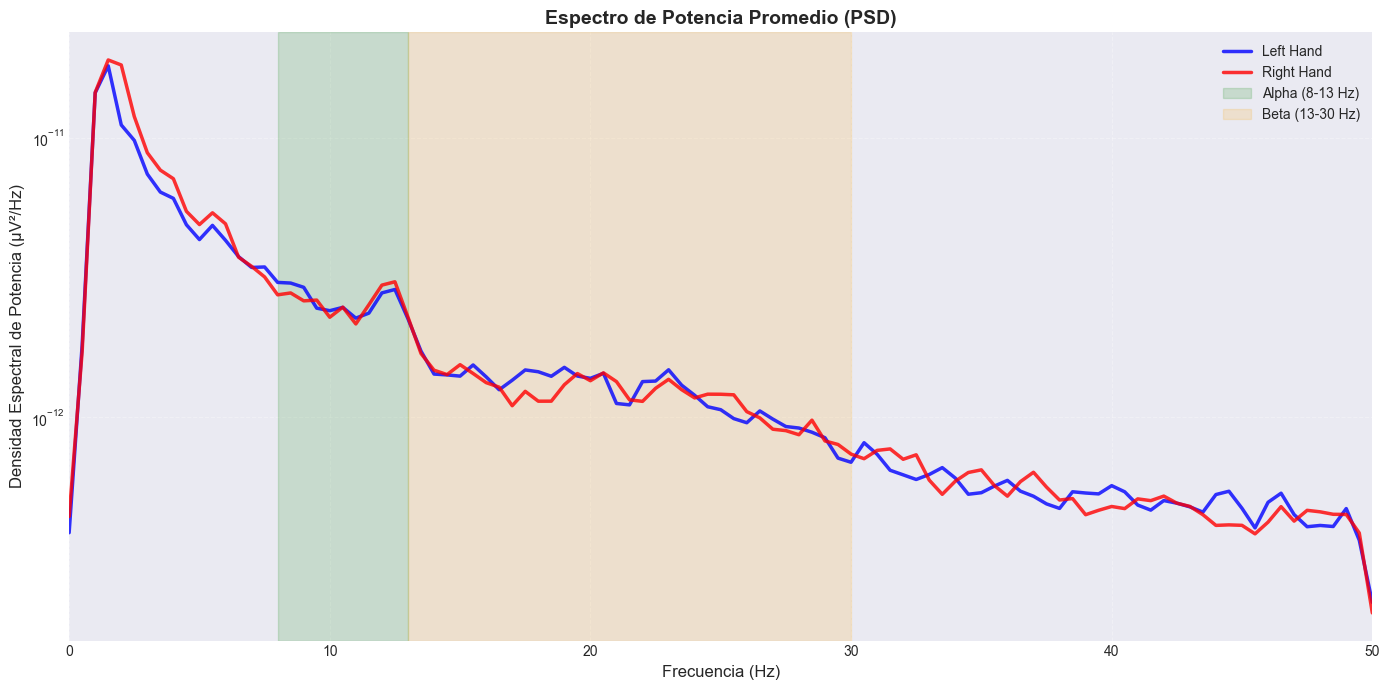


Diagnóstico de frecuencias:
Rango de frecuencias: 0.00 - 50.00 Hz
Número de puntos en Alpha: 11
Número de puntos en Beta: 35
PSD Left - min: 2.179006e-13, max: 1.814348e-11, mean: 1.943720e-12
PSD Right - min: 1.996668e-13, max: 1.904401e-11, mean: 2.088764e-12

Potencia promedio en bandas de frecuencia:
Alpha (8-13 Hz):
Left:  2.627322e-12 μV²/Hz
Right: 2.597454e-12 μV²/Hz
Beta (13-30 Hz):
Left:  1.254973e-12 μV²/Hz
Right: 1.230326e-12 μV²/Hz

Potencia (formato legible):
Alpha (8-13 Hz):
Left:  2.63e-12 μV²/Hz
Right: 2.60e-12 μV²/Hz
Beta (13-30 Hz):
Left:  1.25e-12 μV²/Hz
Right: 1.23e-12 μV²/Hz


In [26]:
# 5.3 Análisis espectral (PSD)
if len(data_info['left']) > 0 and len(data_info['right']) > 0:
    print("Calculando análisis espectral (PSD)...")
    
    # Calcular PSD para algunos trials
    n_trials_psd = min(5, len(data_info['left']), len(data_info['right']))
    print(f"Analizando {n_trials_psd} trials de cada clase")
    
    left_psds = []
    right_psds = []
    valid_left = 0
    valid_right = 0
    
    for i in range(n_trials_psd):
        try:
            left_data = data_info['left'][i]['data']
            right_data = data_info['right'][i]['data']
            
            # Asegurar que los datos estén en formato (channels, time)
            if len(left_data.shape) == 2:
                if left_data.shape[0] > left_data.shape[1]:
                    left_data = left_data.T
            if len(right_data.shape) == 2:
                if right_data.shape[0] > right_data.shape[1]:
                    right_data = right_data.T
            
            # Verificar que los datos tengan variación
            if np.std(left_data) < 1e-6:
                print(f"Trial left {i+1}: señal parece constante, omitiendo")
                continue
            if np.std(right_data) < 1e-6:
                print(f"Trial right {i+1}: señal parece constante, omitiendo")
                continue
            
            # Calcular PSD para cada canal y luego promediar
            # Esto es más robusto que promediar primero y luego calcular PSD
            left_psds_channels = []
            right_psds_channels = []
            
            for ch in range(left_data.shape[0]):
                left_channel = left_data[ch, :]
                # Verificar que el canal tenga variación
                if np.std(left_channel) > 1e-6:
                    nperseg_val = min(256, len(left_channel)//4)
                    # Usar scipy.signal explícitamente para evitar conflictos con variables locales
                    from scipy.signal import welch
                    freqs, psd = welch(left_channel, fs=CONFIG['sampling_rate'], nperseg=nperseg_val)
                    left_psds_channels.append(psd)
            
            for ch in range(right_data.shape[0]):
                right_channel = right_data[ch, :]
                # Verificar que el canal tenga variación
                if np.std(right_channel) > 1e-6:
                    nperseg_val = min(256, len(right_channel)//4)
                    # Usar scipy.signal explícitamente para evitar conflictos con variables locales
                    from scipy.signal import welch
                    freqs, psd = welch(right_channel, fs=CONFIG['sampling_rate'], nperseg=nperseg_val)
                    right_psds_channels.append(psd)
            
            # Si encontramos PSDs válidas, promediarlas
            if len(left_psds_channels) > 0:
                left_psd_avg = np.mean(left_psds_channels, axis=0)
                left_psds.append(left_psd_avg)
                valid_left += 1
            
            if len(right_psds_channels) > 0:
                right_psd_avg = np.mean(right_psds_channels, axis=0)
                right_psds.append(right_psd_avg)
                valid_right += 1
                
        except Exception as e:
            print(f"Error procesando trial {i+1}: {e}")
            continue
    
    if len(left_psds) == 0 or len(right_psds) == 0:
        print(f"No se pudieron calcular PSDs válidas")
        print(f"Left válidos: {valid_left}/{n_trials_psd}")
        print(f"Right válidos: {valid_right}/{n_trials_psd}")
    else:
        print(f"PSDs calculadas: {len(left_psds)} left, {len(right_psds)} right")
        
                         # Promediar PSDs de todos los trials válidos
        left_psd_mean = np.mean(left_psds, axis=0)
        right_psd_mean = np.mean(right_psds, axis=0)
        
        # Calcular frecuencias para el plot (usar el mismo nperseg que se usó)
        # Necesitamos recalcular para obtener las frecuencias
        from scipy.signal import welch
        sample_data = data_info['left'][0]['data']
        if len(sample_data.shape) == 2 and sample_data.shape[0] > sample_data.shape[1]:
            sample_data = sample_data.T
        if sample_data.shape[0] > 0:
            nperseg_val = min(256, sample_data.shape[1]//4)
            freqs, _ = welch(sample_data[0, :], fs=CONFIG['sampling_rate'], nperseg=nperseg_val)
        
        fig, ax = plt.subplots(figsize=(14, 7))
        
        # Filtrar frecuencias de interés (0-50 Hz)
        freq_mask = freqs <= 50
        
        # Plotear PSDs
        ax.semilogy(freqs[freq_mask], left_psd_mean[freq_mask], label='Left Hand', 
                   linewidth=2.5, color='blue', alpha=0.8)
        ax.semilogy(freqs[freq_mask], right_psd_mean[freq_mask], label='Right Hand', 
                   linewidth=2.5, color='red', alpha=0.8)
        
        # Marcar bandas de frecuencia relevantes
        ax.axvspan(8, 13, alpha=0.15, color='green', label='Alpha (8-13 Hz)')
        ax.axvspan(13, 30, alpha=0.15, color='orange', label='Beta (13-30 Hz)')
        
        ax.set_xlabel('Frecuencia (Hz)', fontsize=12)
        ax.set_ylabel('Densidad Espectral de Potencia (μV²/Hz)', fontsize=12)
        ax.set_title('Espectro de Potencia Promedio (PSD)', fontsize=14, fontweight='bold')
        ax.legend(fontsize=10, loc='best')
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.set_xlim(0, 50)
        
        plt.tight_layout()
        plt.savefig(Path(CONFIG['results_dir']) / 'eda_psd.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        # Análisis adicional: comparar potencia en bandas Alpha y Beta
        # Usar las frecuencias filtradas para las máscaras
        freqs_filtered = freqs[freq_mask]
        left_psd_filtered = left_psd_mean[freq_mask]
        right_psd_filtered = right_psd_mean[freq_mask]
        
        # Crear máscaras para las bandas de frecuencia
        alpha_mask = (freqs_filtered >= 8) & (freqs_filtered <= 13)
        beta_mask = (freqs_filtered >= 13) & (freqs_filtered <= 30)
        
        # Diagnóstico
        print(f"\nDiagnóstico de frecuencias:")
        print(f"Rango de frecuencias: {freqs_filtered.min():.2f} - {freqs_filtered.max():.2f} Hz")
        print(f"Número de puntos en Alpha: {np.sum(alpha_mask)}")
        print(f"Número de puntos en Beta: {np.sum(beta_mask)}")
        print(f"PSD Left - min: {np.min(left_psd_filtered):.6e}, max: {np.max(left_psd_filtered):.6e}, mean: {np.mean(left_psd_filtered):.6e}")
        print(f"PSD Right - min: {np.min(right_psd_filtered):.6e}, max: {np.max(right_psd_filtered):.6e}, mean: {np.mean(right_psd_filtered):.6e}")
        
        # Calcular potencia promedio en cada banda
        if np.sum(alpha_mask) > 0:
            left_alpha_power = np.mean(left_psd_filtered[alpha_mask])
            right_alpha_power = np.mean(right_psd_filtered[alpha_mask])
        else:
            left_alpha_power = 0.0
            right_alpha_power = 0.0
            print(f"ADVERTENCIA: No se encontraron frecuencias en el rango Alpha (8-13 Hz)")
        
        if np.sum(beta_mask) > 0:
            left_beta_power = np.mean(left_psd_filtered[beta_mask])
            right_beta_power = np.mean(right_psd_filtered[beta_mask])
        else:
            left_beta_power = 0.0
            right_beta_power = 0.0
            print(f"ADVERTENCIA: No se encontraron frecuencias en el rango Beta (13-30 Hz)")
        
        print(f"\nPotencia promedio en bandas de frecuencia:")
        print(f"Alpha (8-13 Hz):")
        print(f"Left:  {left_alpha_power:.6e} μV²/Hz")
        print(f"Right: {right_alpha_power:.6e} μV²/Hz")
        print(f"Beta (13-30 Hz):")
        print(f"Left:  {left_beta_power:.6e} μV²/Hz")
        print(f"Right: {right_beta_power:.6e} μV²/Hz")
        
        # Mostrar también en notación científica más legible
        print(f"\nPotencia (formato legible):")
        print(f"Alpha (8-13 Hz):")
        print(f"Left:  {left_alpha_power:.2e} μV²/Hz")
        print(f"Right: {right_alpha_power:.2e} μV²/Hz")
        print(f"Beta (13-30 Hz):")
        print(f"Left:  {left_beta_power:.2e} μV²/Hz")
        print(f"Right: {right_beta_power:.2e} μV²/Hz")
else:
    print("No hay suficientes datos para análisis espectral")


In [27]:
# Resumen ejecutivo
# Calcular all_subjects si no está definido
if 'all_subjects' not in locals() or len(data_info['left']) == 0:
    all_subjects = []
    if len(data_info['left']) > 0:
        all_subjects = sorted(set([item['subject_id'] for item in data_info['left'] if item['subject_id'] is not None]))
    if len(data_info['right']) > 0:
        right_subjects = set([item['subject_id'] for item in data_info['right'] if item['subject_id'] is not None])
        all_subjects = sorted(set(all_subjects) | right_subjects)

# Asegurar que df_left y df_right estén definidos
if 'df_left' not in locals() or len(df_left) == 0:
    df_left = pd.DataFrame()
if 'df_right' not in locals() or len(df_right) == 0:
    df_right = pd.DataFrame()

summary = {
    'total_trials': len(data_info['left']) + len(data_info['right']),
    'left_trials': len(data_info['left']),
    'right_trials': len(data_info['right']),
    'n_subjects': len(all_subjects) if len(all_subjects) > 0 else 0,
    'balance_ratio': len(data_info['left']) / len(data_info['right']) if len(data_info['right']) > 0 else 0,
    'avg_channels': df_left['n_channels'].mean() if len(df_left) > 0 else 0,
    'avg_samples': df_left['n_samples'].mean() if len(df_left) > 0 else 0,
    'date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

print("="*70)
print("RESUMEN EJECUTIVO - ANÁLISIS EXPLORATORIO DE DATOS")
print("="*70)
print(f"\nDATOS GENERALES:")
print(f"- Total de trials: {summary['total_trials']}")
print(f"- Trials Left Hand: {summary['left_trials']}")
print(f"- Trials Right Hand: {summary['right_trials']}")
print(f"- Ratio de balance: {summary['balance_ratio']:.3f}")
print(f"- Número de sujetos: {summary['n_subjects']}")
print(f"\nDIMENSIONES:")
print(f"- Canales promedio: {summary['avg_channels']:.1f}")
print(f"- Muestras promedio por trial: {summary['avg_samples']:.1f}")
print(f"- Frecuencia de muestreo: {CONFIG['sampling_rate']} Hz")

print(f"\nVERIFICACIONES:")
print(f"- Balance de clases: {'Balanceado' if 0.9 < summary['balance_ratio'] < 1.1 else 'Desbalanceado'}")
print(f"- Integridad de datos: {len(data_info['left']) + len(data_info['right'])}/{summary['total_trials']} trials cargados")

# Guardar resumen
with open(Path(CONFIG['results_dir']) / 'eda_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print(f"\nResumen guardado en: {Path(CONFIG['results_dir']) / 'eda_summary.json'}")
print("="*70)


RESUMEN EJECUTIVO - ANÁLISIS EXPLORATORIO DE DATOS

DATOS GENERALES:
- Total de trials: 40
- Trials Left Hand: 20
- Trials Right Hand: 20
- Ratio de balance: 1.000
- Número de sujetos: 20

DIMENSIONES:
- Canales promedio: 64.0
- Muestras promedio por trial: 1152.0
- Frecuencia de muestreo: 128 Hz

VERIFICACIONES:
- Balance de clases: Balanceado
- Integridad de datos: 40/40 trials cargados

Resumen guardado en: results/eda_summary.json
